# Initialization

## Setup

In [1]:
# MODEL_NAME = 'gpt2-large'
# MODEL_NAME = 'gpt2-xl'
# MODEL_NAME = 'EleutherAI/gpt-j-6B'
MODEL_NAME = "meta-llama/Llama-2-13b-hf"
# MODEL_NAME = "meta-llama/Llama-2-7b-hf"
# MODEL_NAME = 'openlm-research/open_llama_3b'
# MODEL_NAME = "meta-llama/Meta-Llama-3-8B"
# MODEL_NAME = 'mistralai/Mistral-7B-v0.1'


In [2]:
hf_token = '<YOUR_HUGGING_FACE_TOKEN>'

In [3]:
device = 'cuda'


<span style="font-size: 16px; color: red;">WARNING: this will change the files in your python modules:</span>
<br><br>
The line `python apply_patches.py` will change the files in your python modules `torch/nn/modules/linear.py` and `transformers/models/llama/modeling_llama.py`
<br>
In order to make it possible to use TunedLens (needed for the third experiment) with models distributed across multiple GPUs, we use this workaround.
<br>
However it creates backups of the original versions of the files as linear.py.bak and modeling_llama.py.bak in the corresponding directories.


In [6]:
# !pip install transformers==4.38.2
# !python apply_patches.py

Backup created at /opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py.bak
Copied /kaggle/working/patches/torch/nn/modules/linear.py to /opt/conda/lib/python3.10/site-packages/torch/nn/modules/linear.py
Backup created at /opt/conda/lib/python3.10/site-packages/transformers/models/llama/modeling_llama.py.bak
Copied /kaggle/working/patches/transformers/models/llama/modeling_llama.py to /opt/conda/lib/python3.10/site-packages/transformers/models/llama/modeling_llama.py


## Load the modules

In [7]:

%load_ext autoreload
%autoreload 2


In [ ]:
!pip install gdown munch

In [ ]:
from experiment import Experiment, ExperimentSetup, ExperimentManager
from context_wrapper import ContextWrapper
from tokens_to_check import TokensToCheck as TokensToCheckOriginal
from tuned_lens.nn.lenses import TunedLens, LogitLens

In [9]:
import torch
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer

import torch.nn.functional as F
from torch.nn.functional import softmax

from torch.distributions.categorical import Categorical
from torch.distributions.kl import kl_divergence

import yaml

import traceback

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()

In [10]:
def get_model_path(MODEL_NAME):
    if '/' in MODEL_NAME:
        model_path = MODEL_NAME

    elif MODEL_NAME.startswith('llama_'):
        version = MODEL_NAME.split('_')[1]
        model_path = f'/kaggle/input/open-llama/pytorch/{version}/1/'

    elif 'gpt2' in MODEL_NAME:
        model_path = MODEL_NAME
        
    elif 'gpt-j' in MODEL_NAME:
        model_path = MODEL_NAME

    else:
        raise NotImplementedError()
        
    return model_path

model_path = get_model_path(MODEL_NAME)
print("Using", model_path)

Using meta-llama/Llama-2-13b-hf


In [11]:
if 'model' not in globals():
    model = AutoModelForCausalLM.from_pretrained(model_path, device_map="auto",
                                                 torch_dtype=torch.bfloat16, token=hf_token,)
    tokenizer = AutoTokenizer.from_pretrained(model_path, token=hf_token)
        
TOKENIZER_WORD_SEP = tokenizer.tokenize(' hello')[0][0]
IS_SPACE_ENCODED_SEPARATELY = len(tokenizer.tokenize(' a')) > 1
IS_BOS_USED = tokenizer.bos_token_id == tokenizer('hello').input_ids[0]

TokensToCheck = ContextWrapper(TokensToCheckOriginal,
                               add_space=not IS_SPACE_ENCODED_SEPARATELY,
                               tokenizer=tokenizer,)

print(f'Model: {model_path} loaded\nseparator: {TOKENIZER_WORD_SEP}\nIS_SPACE_ENCODED_SEPARATELY {IS_SPACE_ENCODED_SEPARATELY}\nis bos used? {IS_BOS_USED}\n{str(model)}')

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Model: meta-llama/Llama-2-13b-hf loaded
separator: ▁
IS_SPACE_ENCODED_SEPARATELY True
is bos used? True
LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 5120)
    (layers): ModuleList(
      (0-39): 40 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (k_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (v_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (o_proj): Linear(in_features=5120, out_features=5120, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (up_proj): Linear(in_features=5120, out_features=13824, bias=False)
          (down_proj): Linear(in_features=13824, out_features=5120, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
    

In [12]:
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [13]:

from utils import Utils

utils = Utils(model, tokenizer)

find_sublist_indices = utils.find_sublist_indices
get_token_positions = utils.get_token_positions
create_zero_out_mask = utils.create_zero_out_mask
get_hidden_states = utils.get_hidden_states
compare_hidden_states = utils.compare_hidden_states

In [14]:
NUM_OF_LAYERS = utils.num_of_layers

In [15]:
from IPython.display import display, HTML

def generate_and_display_highlited(text_original, description='', max_length=50):
    with torch.no_grad():
        generated = tokenizer.decode(
            model.generate(
                tokenizer(text_original, return_tensors='pt').input_ids.to(model.device),
                max_length=max_length
            )[0],
            skip_special_tokens=True,
        )

    highlighted_html = f'''
        <span style="color: inherit; opacity: 0.15">{description}</span>
        <span style="color: blue; font-weight: bold">{text_original}</span>{generated[len(text_original):]}
    '''
    display(HTML(highlighted_html))


In [16]:
def get_top_n_tokens(prompt, n=7):
    assert len(set(tokenizer.get_vocab().values())) == len(tokenizer.get_vocab())
    input_ids = tokenizer(prompt, return_tensors="pt")['input_ids']

    with torch.no_grad():
        outputs = model(input_ids.to(model.device), use_cache=False)

    probabilities = F.softmax(outputs['logits'], dim=-1)
    last_token_probabilities = probabilities[0, -1, :]

    top_indices = torch.argsort(last_token_probabilities, descending=True)[:n]
    decoded_with_probs = [f'{utils.vocab_reverse[int(idx.item())]}: ' +
                          f'{last_token_probabilities[idx].item():.2f}' for idx in top_indices]#[:n]
    
    return decoded_with_probs[:]

In [17]:
vocab = tokenizer.get_vocab()
vocab_reverse =  {v: k for k, v in vocab.items()}

In [18]:

def get_top_n_tokens(prompt, n=7):
    assert len(set(tokenizer.get_vocab().values())) == len(tokenizer.get_vocab())
    input_ids = tokenizer(prompt, return_tensors="pt")['input_ids']

    with torch.no_grad():
        outputs = model(input_ids.to(model.device))

    probabilities = F.softmax(outputs['logits'], dim=-1)
    last_token_probabilities = probabilities[0, -1, :]

    top_indices = torch.argsort(last_token_probabilities, descending=True)[:n]
    decoded_with_probs = [f'{utils.vocab_reverse[int(idx.item())]}: ' +
                          f'{last_token_probabilities[idx].item():.2f}' for idx in top_indices]#[:n]
    
    return decoded_with_probs[:]

In [19]:
def token_rank_in_logits(logits, token_id):
    sorted_indices = torch.argsort(logits, descending=True)
    rank = (sorted_indices == token_id).nonzero(as_tuple=True)[0].item()
    return rank + 1  # Adding 1 because rank starts from 1


def get_ranks_for_prompt(prompt, tokens_to_check):
    with torch.no_grad():
        print(f'Ranks for the next token for the prompt "{prompt}" are:')
        outputs = model(tokenizer(prompt, return_tensors="pt").input_ids.to(model.device))
        
        probabilities = softmax(outputs.logits[0, -1], dim=0)

        for tok_kind, tok in zip(['original', 'target', 'control'],
                       [tokens_to_check.original, tokens_to_check.target, tokens_to_check.control]):
            token_id = utils.vocab[tok]
            token_probability = probabilities[token_id].item()
            token_rank = token_rank_in_logits(outputs.logits[0, -1], token_id)
            
            print(f"{tok} ({tok_kind}): Rank = {token_rank}, Probability = {token_probability:.5f}")


In [20]:
def extract_data_from_fig(fig):
    subplot_data = []
    for i, ax in enumerate(fig.axes):
        # Checking if the axis is an inset by looking for a specific attribute or method
        is_inset = hasattr(ax, 'in_axes')

        data_dict = {
            'subplot_index': i,
            'is_inset': is_inset,
            'title': ax.get_title(),
            'xlabel': ax.get_xlabel(),
            'ylabel': ax.get_ylabel(),
            'plots': []
        }

        for line in ax.lines:
            data_dict['plots'].append({
                'type': 'line',
                'x_data': line.get_xdata().tolist(),
                'y_data': line.get_ydata().tolist(),
                'label': line.get_label(),
                'color': line.get_color(),
                'marker': line.get_marker(),
                'linestyle': line.get_linestyle()
            })

        subplot_data.append(data_dict)

    return subplot_data


In [21]:
from tuned_lens.plotting import PredictionTrajectory

class Lensing:
    def __init__(self, model):
        self.model = model
        self._tuned_lens = None
        self._logit_lens = None

    @property
    def tuned_lens(self):
        if self._tuned_lens is None:
            self._tuned_lens = TunedLens.from_model_and_pretrained(model, lens_resource_id=self.model.config.name_or_path).to(device)

        return self._tuned_lens
    
    @property
    def logit_lens(self):
        if self._logit_lens is None:
            self._logit_lens = LogitLens.from_model(self.model)

        return self._logit_lens

    def make_lens_trajectory(self, text, lens=None, statistic='entropy', token_range=None, regime='tuned_lens', **kwargs):
        
        assert regime in ['tuned_lens', 'logit_lens']
        assert statistic in ['entropy', 'kl_divergence', 'forward_kl']

        input_ids = tokenizer.encode(text)
        targets = input_ids[1:] + [tokenizer.eos_token_id]

        if len(input_ids) == 0:
            raise ValueError("Please enter some text.")

        if token_range is None:
            token_range = (0, len(input_ids))
        elif token_range[0] == token_range[1]:
            raise ValueError("Please provide valid token range.")

        if lens is None:
            lens = getattr(self, regime)
            
        pred_traj = PredictionTrajectory.from_lens_and_model(
            lens=lens,
            model=model,
            input_ids=input_ids,
            tokenizer=tokenizer,
            targets=targets,
        ).slice_sequence(slice(*token_range))
        statistic_result = getattr(pred_traj, statistic)(**kwargs)

        return pred_traj, statistic_result
    
    def visualize_statistic(self, statistic_result, title=None, layer_stride=1):
        
        plot = statistic_result.stride(layer_stride).figure(
            title=f"{lens.__class__.__name__} ({model.name_or_path}) {statistic}" if title is None else title,
            token_width=55,

            textfont=dict(size=10),
        )
        plot.update_layout(height=700)
        plot.show()


lensing = Lensing(model)

In [22]:
with open('experiments.yaml', 'r', encoding='utf-8') as f:
    experiment_templates = yaml.safe_load(f)

for experiment in experiment_templates:
    experiment['tokens_to_check'] = TokensToCheck(**experiment['tokens_to_check']) if isinstance(experiment['tokens_to_check'], dict) else experiment['tokens_to_check']
        

# The plateau and the "Research Question #2" experiment

In [34]:

experiment_setup = ExperimentSetup(

    model_name=MODEL_NAME,

    residual=True,
    compare_lens=True,  # set to False if you do not want to see the results of the "Research Question #2" experiment
    show_graphs=False,

    replacement_method='exact',
    zero_out_following=True,

    compare_lens_kwargs=dict(visualize_stat=True, token_index=-1, zero_out_following=False,
                             layer_nums_target=10, layer_nums_original=10, regime='tuned_lens'),
    show_graphs_kwargs=None,
 )
experiment_manager = ExperimentManager(utils=utils,
                                       lensing=lensing,
                                       experiment_setup=experiment_setup,
                                       tokenizer_word_sep=TOKENIZER_WORD_SEP,
                                       model_name=MODEL_NAME,
                                      )

utils = Utils(model, tokenizer)

First, the code checks whether the model correctly completes the prompt of the given experiment and whether the model assigns a high probability to the correct answer.
<br>
Thus, we can be confident that the model "knows" the fact about the subject.
<br>
As a rule of thumb, weaker models perform worse than larger ones.


  0%|          | 0/10 [00:00<?, ?it/s]

Original prompt: "The Eiffel Tower is located in the city of"; ▁Paris tprob: 0.946, top token: ▁Paris with prob: 0.946
Target prompt: "The Colosseum is located in the city of"; ▁Rome tprob: 0.881, top token: ▁Rome with prob: 0.881
['▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']
['▁The', '▁Col', 'os', 'se', 'um', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']
Adding experiment Experiment(
    text_template='{} is located in the city of',
    subject_original='The Eiffel Tower',
    subject_target='The Colosseum',
    tokens_to_check='TokensToCheck(original_word='Paris', target_word='Rome', control_word='Madrid',
original='▁Paris', target='▁Rome', control='▁Madrid')'
)
['▁The', '▁E', 'iff', 'el', '▁Tower']
['▁The', '▁Col', 'os', 'se', 'um']


  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} is located in the city of',
    subject_original='The Eiffel Tower',
    subject_target='The Colosseum',
    tokens_to_check='TokensToCheck(original_word='Paris', target_word='Rome', control_word='Madrid',
original='▁Paris', target='▁Rome', control='▁Madrid')'
)
['▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']
['▁The', '▁Col', 'os', 'se', 'um', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']
{'original': 0.00021826209558639675, 'target': 0.9466612935066223, 'control': 0.000280254113022238}


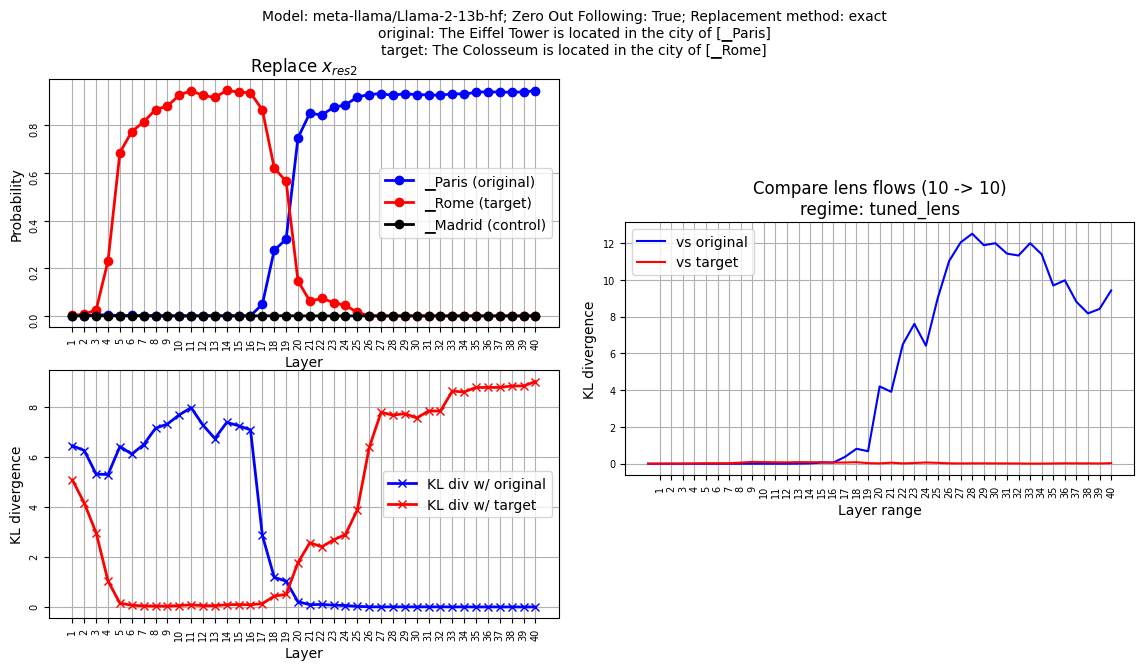

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']` 
 target: `['▁The', '▁Col', 'os', 'se', 'um', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']` 
 
 Experiment(
    text_template='{} is located in the city of',
    subject_original='The Eiffel Tower',
    subject_target='The Colosseum',
    tokens_to_check='TokensToCheck(original_word='Paris', target_word='Rome', control_word='Madrid',
original='▁Paris', target='▁Rome', control='▁Madrid')'
) 

Original prompt: "Cherokee are a tribe from the continent of"; ▁North tprob: 0.620, top token: ▁North with prob: 0.620
Target prompt: "The Zulus are a tribe from the continent of"; ▁Africa tprob: 0.929, top token: ▁Africa with prob: 0.929
['▁Ch', 'ero', 'kee', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']
['▁The', '▁Z', 'ulus', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']
Adding experiment Experiment(
    text_t

  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} are a tribe from the continent of',
    subject_original='Cherokee',
    subject_target='The Zulus',
    tokens_to_check='TokensToCheck(original_word='North America', target_word='Africa', control_word='Australia',
original='▁North', target='▁Africa', control='▁Australia')'
)
['▁Ch', 'ero', 'kee', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']
['▁The', '▁Z', 'ulus', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']
{'original': 0.0016044944059103727, 'target': 0.8847532272338867, 'control': 0.0010359394364058971}


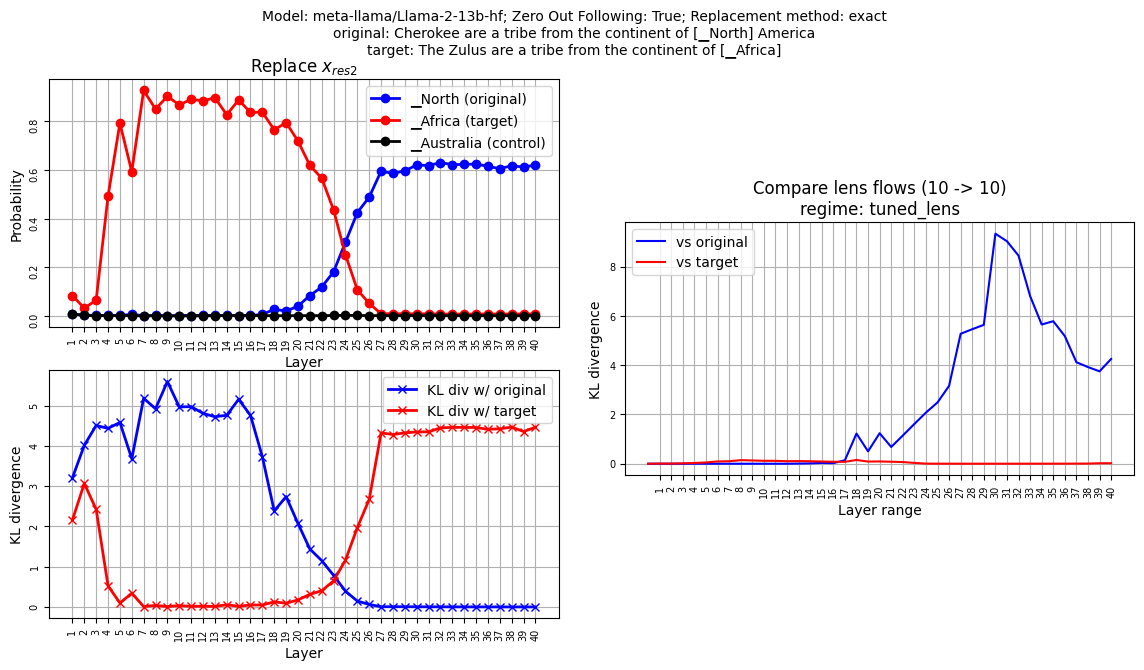

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁Ch', 'ero', 'kee', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']` 
 target: `['▁The', '▁Z', 'ulus', '▁are', '▁a', '▁tribe', '▁from', '▁the', '▁continent', '▁of']` 
 
 Experiment(
    text_template='{} are a tribe from the continent of',
    subject_original='Cherokee',
    subject_target='The Zulus',
    tokens_to_check='TokensToCheck(original_word='North America', target_word='Africa', control_word='Australia',
original='▁North', target='▁Africa', control='▁Australia')'
) 

Original prompt: "Skype is a program used for"; ▁video tprob: 0.178, top token: ▁video with prob: 0.178


Original prompt: "The matador is a profession that deals with animals such as"; ▁b tprob: 0.717, top token: ▁b with prob: 0.717
Target prompt: "Cynologist is a profession that deals with animals such as"; ▁dogs tprob: 0.737, top token: ▁dogs with prob: 0.737
['▁The', '▁mat', 'ador', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']
['▁C', 'yn', 'ologist', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']
Adding experiment Experiment(
    text_template='{} is a profession that deals with animals such as',
    subject_original='The matador',
    subject_target='Cynologist',
    tokens_to_check='TokensToCheck(original_word='bulls', target_word='dogs', control_word='cats',
original='▁b', target='▁dogs', control='▁c')'
)
['▁The', '▁mat', 'ador']
['▁C', 'yn', 'ologist']


  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} is a profession that deals with animals such as',
    subject_original='The matador',
    subject_target='Cynologist',
    tokens_to_check='TokensToCheck(original_word='bulls', target_word='dogs', control_word='cats',
original='▁b', target='▁dogs', control='▁c')'
)
['▁The', '▁mat', 'ador', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']
['▁C', 'yn', 'ologist', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']
{'original': 0.0009688007412478328, 'target': 0.6859492659568787, 'control': 0.04969000071287155}


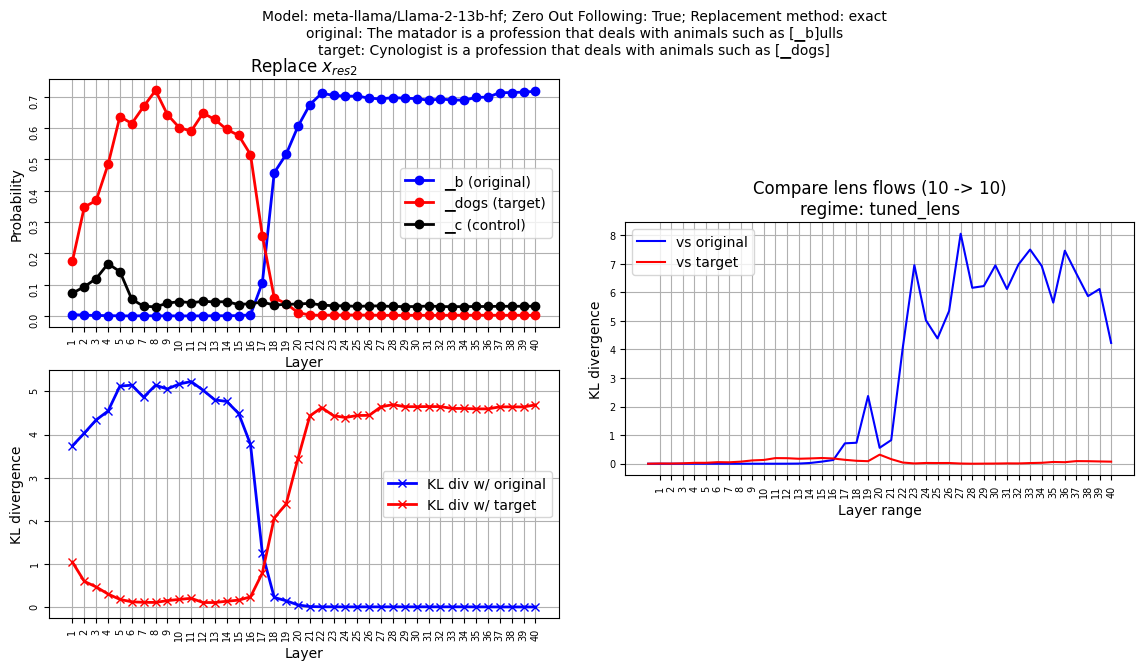

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁The', '▁mat', 'ador', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']` 
 target: `['▁C', 'yn', 'ologist', '▁is', '▁a', '▁profession', '▁that', '▁de', 'als', '▁with', '▁animals', '▁such', '▁as']` 
 
 Experiment(
    text_template='{} is a profession that deals with animals such as',
    subject_original='The matador',
    subject_target='Cynologist',
    tokens_to_check='TokensToCheck(original_word='bulls', target_word='dogs', control_word='cats',
original='▁b', target='▁dogs', control='▁c')'
) 

Original prompt: "The collie is a breed of"; ▁dog tprob: 0.264, top token: ▁her with prob: 0.319


Original prompt: "Ophthalmologist is a doctor who treats diseases of the"; ▁eye tprob: 0.695, top token: ▁eye with prob: 0.695
Target prompt: "The the cardiologist is a doctor who treats diseases of the"; ▁heart tprob: 0.793, top token: ▁heart with prob: 0.793
['▁O', 'ph', 'th', 'alm', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']
['▁The', '▁the', '▁card', 'i', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']
Adding experiment Experiment(
    text_template='{} is a doctor who treats diseases of the',
    subject_original='Ophthalmologist',
    subject_target='The the cardiologist',
    tokens_to_check='TokensToCheck(original_word='eye', target_word='heart', control_word='lungs',
original='▁eye', target='▁heart', control='▁l')'
)
['▁O', 'ph', 'th', 'alm', 'ologist']
['▁The', '▁the', '▁card', 'i', 'ologist']


  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} is a doctor who treats diseases of the',
    subject_original='Ophthalmologist',
    subject_target='The the cardiologist',
    tokens_to_check='TokensToCheck(original_word='eye', target_word='heart', control_word='lungs',
original='▁eye', target='▁heart', control='▁l')'
)
['▁O', 'ph', 'th', 'alm', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']
['▁The', '▁the', '▁card', 'i', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']
{'original': 1.1076959708589129e-05, 'target': 0.8000001311302185, 'control': 6.785459845559672e-05}


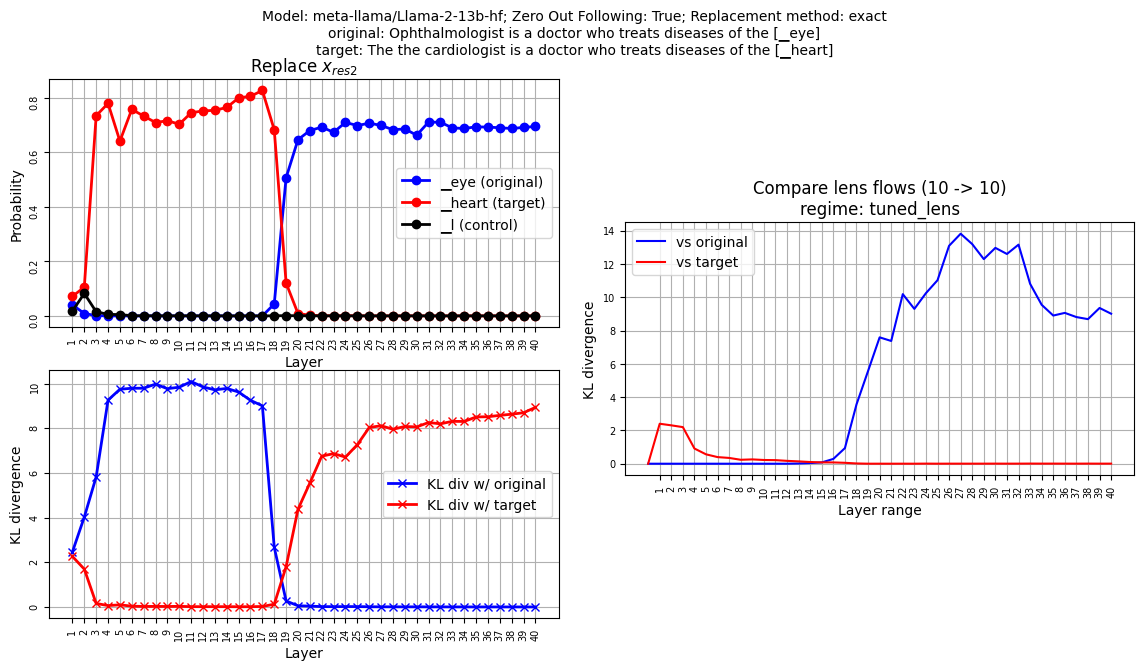

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁O', 'ph', 'th', 'alm', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']` 
 target: `['▁The', '▁the', '▁card', 'i', 'ologist', '▁is', '▁a', '▁doctor', '▁who', '▁tre', 'ats', '▁dise', 'ases', '▁of', '▁the']` 
 
 Experiment(
    text_template='{} is a doctor who treats diseases of the',
    subject_original='Ophthalmologist',
    subject_target='The the cardiologist',
    tokens_to_check='TokensToCheck(original_word='eye', target_word='heart', control_word='lungs',
original='▁eye', target='▁heart', control='▁l')'
) 

Original prompt: "The penguins live on the continent of"; ▁Ant tprob: 0.795, top token: ▁Ant with prob: 0.795
Target prompt: "Kangaroos live on the continent of"; ▁Australia tprob: 0.936, top token: ▁Australia with prob: 0.936
['▁The', '▁p', 'engu', 'ins', '▁live', '▁on', '▁the', '▁continent', '▁of']
['▁K', 'ang', 'aro', 'os', '▁live', '▁on', '▁the', '▁continent', '▁of']

  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} live on the continent of',
    subject_original='The penguins',
    subject_target='Kangaroos',
    tokens_to_check='TokensToCheck(original_word='Antarctica', target_word='Australia', control_word='Africa',
original='▁Ant', target='▁Australia', control='▁Africa')'
)
['▁The', '▁p', 'engu', 'ins', '▁live', '▁on', '▁the', '▁continent', '▁of']
['▁K', 'ang', 'aro', 'os', '▁live', '▁on', '▁the', '▁continent', '▁of']
{'original': 0.0035588464234024286, 'target': 0.8708209991455078, 'control': 0.011669008061289787}


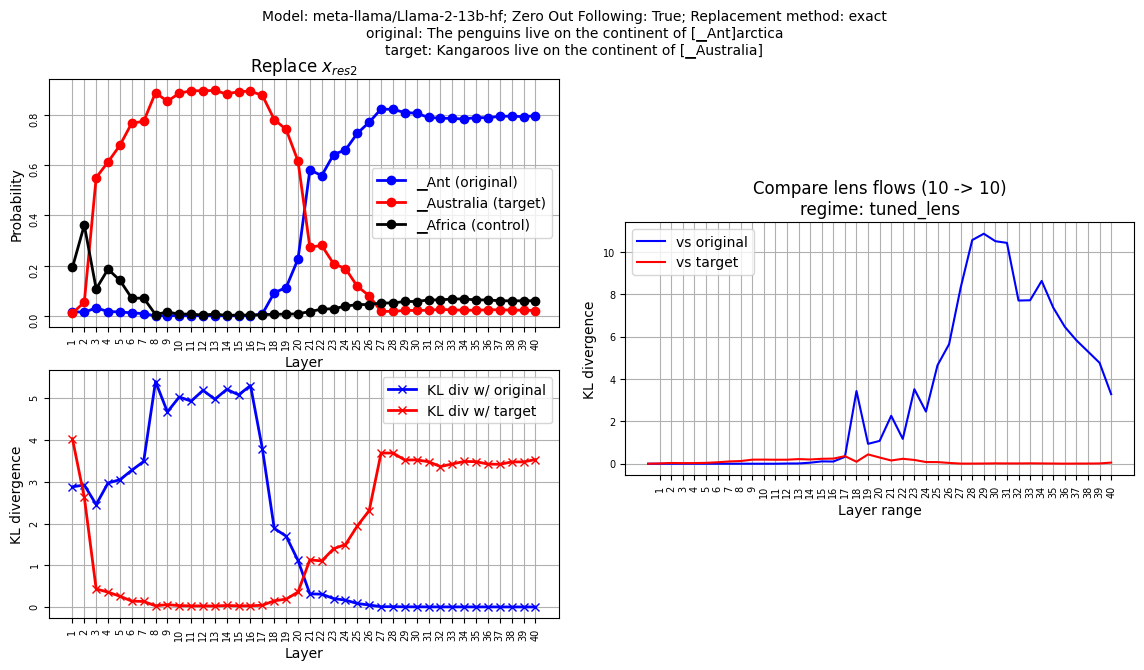

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁The', '▁p', 'engu', 'ins', '▁live', '▁on', '▁the', '▁continent', '▁of']` 
 target: `['▁K', 'ang', 'aro', 'os', '▁live', '▁on', '▁the', '▁continent', '▁of']` 
 
 Experiment(
    text_template='{} live on the continent of',
    subject_original='The penguins',
    subject_target='Kangaroos',
    tokens_to_check='TokensToCheck(original_word='Antarctica', target_word='Australia', control_word='Africa',
original='▁Ant', target='▁Australia', control='▁Africa')'
) 

Original prompt: "The the YouTube is a service whose main content is"; ▁videos tprob: 0.219, top token: ▁the with prob: 0.248


Original prompt: "Bracelet is a piece of jewelry that is worn on the"; ▁w tprob: 0.900, top token: ▁w with prob: 0.900
Target prompt: "The tiara is a piece of jewelry that is worn on the"; ▁head tprob: 0.913, top token: ▁head with prob: 0.913
['▁Bra', 'ce', 'let', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']
['▁The', '▁ti', 'ara', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']
Adding experiment Experiment(
    text_template='{} is a piece of jewelry that is worn on the',
    subject_original='Bracelet',
    subject_target='The tiara',
    tokens_to_check='TokensToCheck(original_word='wrist', target_word='head', control_word='leg',
original='▁w', target='▁head', control='▁leg')'
)
['▁Bra', 'ce', 'let']
['▁The', '▁ti', 'ara']


  0%|          | 0/40 [00:00<?, ?it/s]

compare_lens_kwargs {'visualize_stat': False, 'token_index': -1, 'zero_out_following': False, 'layer_nums_target': 10, 'layer_nums_original': 10, 'regime': 'tuned_lens'}
Experiment(
    text_template='{} is a piece of jewelry that is worn on the',
    subject_original='Bracelet',
    subject_target='The tiara',
    tokens_to_check='TokensToCheck(original_word='wrist', target_word='head', control_word='leg',
original='▁w', target='▁head', control='▁leg')'
)
['▁Bra', 'ce', 'let', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']
['▁The', '▁ti', 'ara', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']
{'original': 0.0002146969345631078, 'target': 0.8747797012329102, 'control': 6.030394388290006e-07}


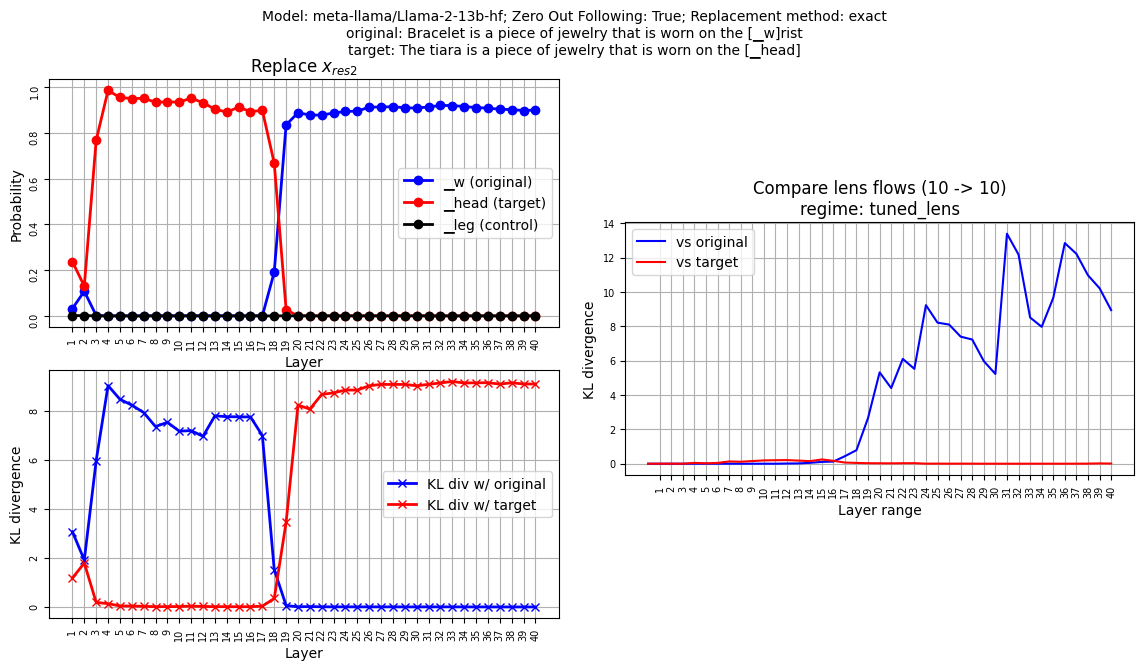

meta-llama/Llama-2-13b-hf 
 residual_kwargs: {} 
 
 original: `['▁Bra', 'ce', 'let', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']` 
 target: `['▁The', '▁ti', 'ara', '▁is', '▁a', '▁piece', '▁of', '▁j', 'ew', 'el', 'ry', '▁that', '▁is', '▁worn', '▁on', '▁the']` 
 
 Experiment(
    text_template='{} is a piece of jewelry that is worn on the',
    subject_original='Bracelet',
    subject_target='The tiara',
    tokens_to_check='TokensToCheck(original_word='wrist', target_word='head', control_word='leg',
original='▁w', target='▁head', control='▁leg')'
) 

Original prompt: "Pork is meat from a"; ▁p tprob: 0.306, top token: ▁domestic with prob: 0.649


In [36]:
for template in tqdm(experiment_templates[:10]):
    result = None

    utils.remove_all_forward_hooks()

    try:
        experiment = Experiment(model, tokenizer, **template)

        text_original_tokenized = tokenizer.tokenize(experiment.text_original)
        text_target_tokenized = tokenizer.tokenize(experiment.text_target)

        print(text_original_tokenized)
        print(text_target_tokenized)
        
        result = experiment_manager.add_experiment(experiment, force=True)
    except Exception as err:
        if 'Top predicted token in the' in err.args[0] or 'below the threshold' in err.args[0]:
            display(HTML(f'<span style="color: green">Skipping {template}: {err}</span>'))
            continue
        
        print(template, traceback.format_exc())

        raise err
        # continue

    if result:
        print(MODEL_NAME, '\n',
              f'residual_kwargs: {experiment_setup.residual_kwargs}', '\n',
              '\n',
              f'original: `{text_original_tokenized}`', '\n',
              f'target: `{text_target_tokenized}`', '\n',
              '\n',
              experiment, '\n')


# The "Research Question #1" experiment:

Original prompt: "The Eiffel Tower is located in the city of"; ▁Paris tprob: 0.946, top token: ▁Paris with prob: 0.946
Target prompt: "The Colosseum is located in the city of"; ▁Rome tprob: 0.881, top token: ▁Rome with prob: 0.881
meta-llama/Llama-2-13b-hf, zero_out_following=False
In CLEAN run with ORIGINAL prompt "['▁The', '▁E', 'iff', 'el', '▁Tower', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']", the top token is: "▁Paris" (0.95)
In CLEAN run with TARGET prompt "['▁The', '▁Col', 'os', 'se', 'um', '▁is', '▁located', '▁in', '▁the', '▁city', '▁of']", the top token is: "▁Rome" (0.88)

In CLEAN run with ORIGINAL prompt "['▁The', '▁E']", the top subject token is: "volution" (0.11)
In CLEAN run with TARGET prompt "['▁The', '▁Col']", the top subject token is: "onial" (0.10)


  0%|          | 0/32 [00:00<?, ?it/s]

In CLEAN run with ORIGINAL prompt "['▁The', '▁E', 'iff']", the top subject token is: "el" (0.99)
In CLEAN run with TARGET prompt "['▁The', '▁Col', 'os']", the top subject token is: "se" (0.90)


  0%|          | 0/32 [00:00<?, ?it/s]

In CLEAN run with ORIGINAL prompt "['▁The', '▁E', 'iff', 'el']", the top subject token is: "▁Tower" (0.88)
In CLEAN run with TARGET prompt "['▁The', '▁Col', 'os', 'se']", the top subject token is: "um" (0.96)


  0%|          | 0/32 [00:00<?, ?it/s]

In CLEAN run with ORIGINAL prompt "['▁The', '▁E', 'iff', 'el', '▁Tower']", the top subject token is: "▁is" (0.30)
In CLEAN run with TARGET prompt "['▁The', '▁Col', 'os', 'se', 'um']", the top subject token is: "▁is" (0.18)


  0%|          | 0/32 [00:00<?, ?it/s]

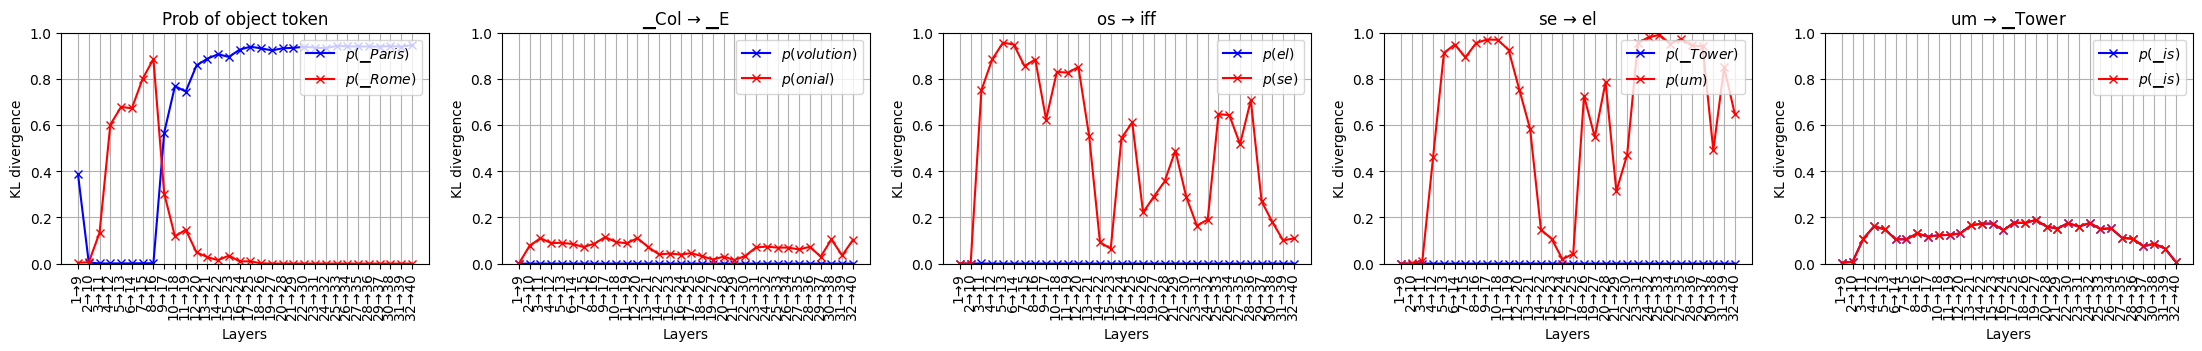

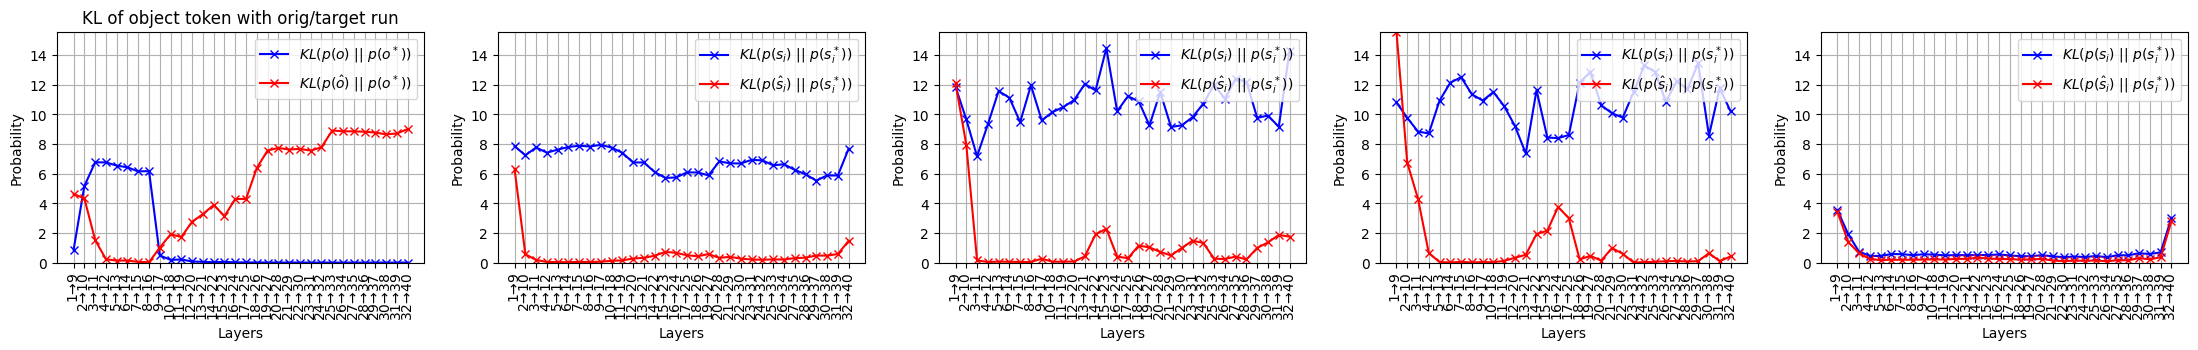

In [26]:
experiment = Experiment(model, tokenizer, **experiment_templates[0])

res = experiment_manager.compare_with_shift(
    experiment,
    shift = 8,
    idx_in_token_positions=[1, 2, 3, 4],
)
